In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

urls = [
    'https://techncruncher.blogspot.com/2025/01/top-10-ai-tools-that-will-transform.html',
    'https://techncruncher.blogspot.com/2023/12/limewire-ai-studio-review-2023-details.html',
    'https://techncruncher.blogspot.com/2023/01/top-10-ai-tools-in-2023-that-will-make.html',
    'https://techncruncher.blogspot.com/2022/11/top-10-ai-content-generator-writer.html',
    'https://techncruncher.blogspot.com/2022/09/cj-affiliate-ultimate-guide-to.html'
]

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
articles = []

for url in urls:
    try:
        # Fetch the page content
        res = requests.get(url, headers=headers, timeout=10)
        res.raise_for_status()
        soup = BeautifulSoup(res.content, 'lxml')

        # Extract Title
        title = soup.find('h3', class_='post-title')
        title = title.get_text(strip=True) if title else soup.title.get_text(strip=True)

        # Extract Body Text
        content_div = soup.find('div', class_='post-body entry-content')
        if not content_div:
            print(f"[SKIP] No content found: {url}")
            continue

        paragraphs = content_div.find_all('p')
        text = ' '.join(p.get_text(strip=True) for p in paragraphs)

        # Skip short articles for quality control
        if len(text) > 100:
            articles.append({'url': url, 'title': title, 'text': text})
        else:
            print(f"[SKIP] Too short: {url}")

        time.sleep(1)  # Be polite to the server

    except Exception as e:
        print(f"[ERROR] {url} -> {e}")

# Create DataFrame at the end
df = pd.DataFrame(articles)
print(f" Scraped {len(df)} articles successfully.")
df.head()


[SKIP] Too short: https://techncruncher.blogspot.com/2022/09/cj-affiliate-ultimate-guide-to.html
 Scraped 4 articles successfully.


,url,title,text
0,https://techncruncher.blogspot.com/2025/01/top...,Top 10 AI Tools That Will Transform Your Conte...,Looking to level up your content creation gam...
1,https://techncruncher.blogspot.com/2023/12/lim...,"LimeWire AI Studio Review 2023: Details, Prici...",In the rapidly advancing landscape of AI tech...
2,https://techncruncher.blogspot.com/2023/01/top...,Top 10 AI Tools in 2023 That Will Make Your Li...,"In this article, we explore the top 10 AI too..."
3,https://techncruncher.blogspot.com/2022/11/top...,Top 10 AI Content Generator & Writer Tools in ...,There are a number of different AI content ...


In [6]:
import spacy
import pandas as pd # Already imported, but listed for context
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")
def extract_features(text):
 """Processes text with spaCy and extracts linguistic features."""
 doc = nlp(text)
 return pd.Series({
 'num_tokens': len(doc),
 'num_sentences': len(list(doc.sents)),
 'num_entities': len(doc.ents),
 'num_nouns': len([t for t in doc if t.pos_ == 'NOUN'])
 })
if not df.empty:
 # Apply the spaCy feature extraction
 features = df['text'].apply(extract_features)
 df = pd.concat([df, features], axis=1)

 # Calculate simple length feature
 df['title_length'] = df['title'].apply(len)

 print("Features extracted successfully.")
 print(df.head(2))
else:
 print("⚠️ No articles found for feature extraction.")

Features extracted successfully.
                                                 url  \
0  https://techncruncher.blogspot.com/2025/01/top...   
1  https://techncruncher.blogspot.com/2023/12/lim...   

                                               title  \
0  Top 10 AI Tools That Will Transform Your Conte...   
1  LimeWire AI Studio Review 2023: Details, Prici...   

                                                text  num_tokens  \
0   Looking to level up your content creation gam...        1188   
1   In the rapidly advancing landscape of AI tech...        1723   

   num_sentences  num_entities  num_nouns  title_length  
0             47            24        321            65  
1             65           103        420            59  


In [7]:
from textblob import TextBlob
def get_sentiment(text):
 """Calculates sentiment polarity and subjectivity using TextBlob."""
 blob = TextBlob(text)
 return pd.Series({
 'sentiment_polarity': blob.sentiment.polarity,
 'sentiment_subjectivity': blob.sentiment.subjectivity
 })
if not df.empty:
 # Apply TextBlob sentiment analysis
 sentiment_features = df['text'].apply(get_sentiment)
 df = pd.concat([df, sentiment_features], axis=1)

 print("Sentiment features extracted successfully.")
 print(df[['title', 'sentiment_polarity', 'sentiment_subjectivity']].head())

Sentiment features extracted successfully.
                                               title  sentiment_polarity  \
0  Top 10 AI Tools That Will Transform Your Conte...            0.229493   
1  LimeWire AI Studio Review 2023: Details, Prici...            0.219387   
2  Top 10 AI Tools in 2023 That Will Make Your Li...            0.197417   
3  Top 10 AI Content Generator & Writer Tools in ...            0.214853   

   sentiment_subjectivity  
0                0.583603  
1                0.573587  
2                0.436441  
3                0.564907  


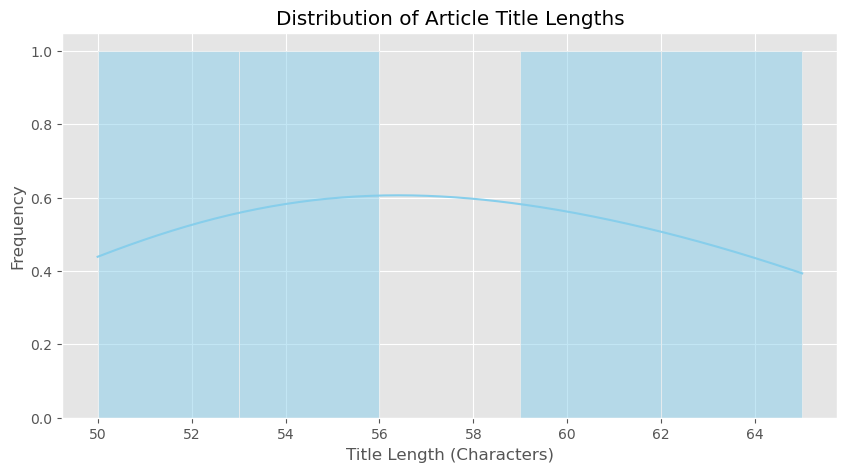

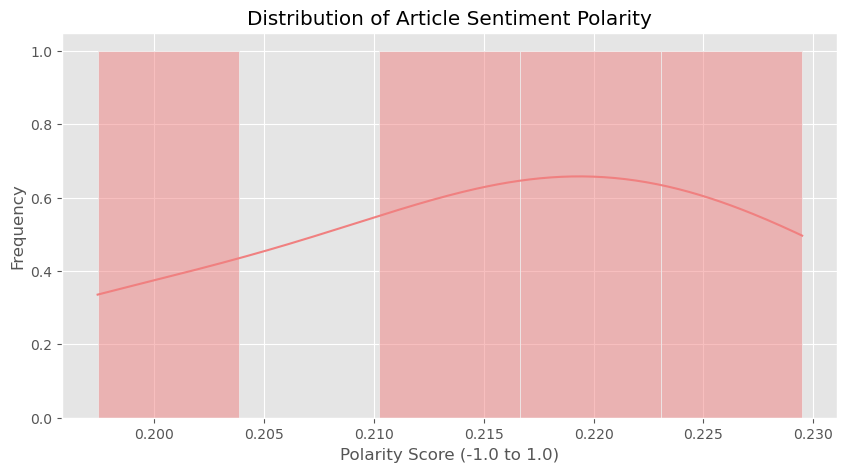

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# 1. Title Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['title_length'], kde=True, bins=5, color='skyblue')
plt.title('Distribution of Article Title Lengths')
plt.xlabel('Title Length (Characters)')
plt.ylabel('Frequency')
plt.show()
# 2. Sentiment Polarity Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment_polarity'], kde=True, bins=5, color='lightcoral')
plt.title('Distribution of Article Sentiment Polarity')
plt.xlabel('Polarity Score (-1.0 to 1.0)')
plt.ylabel('Frequency')
plt.show()


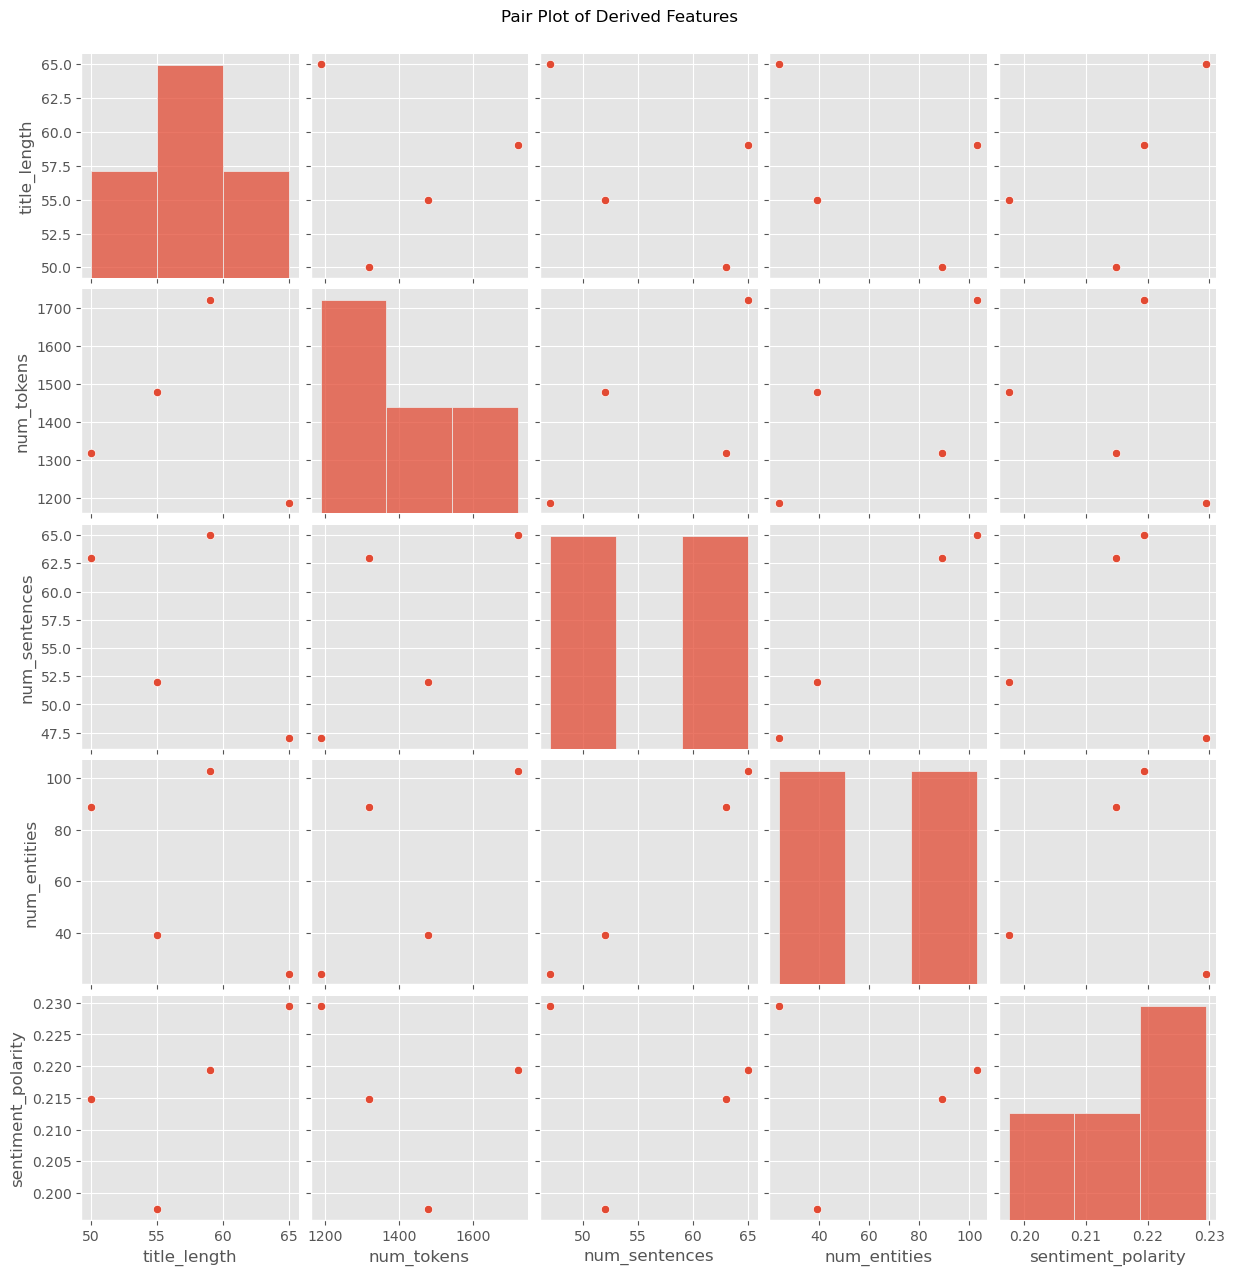

In [9]:
# Select the numeric features for the pair plot
numeric_cols = [
 'title_length',
 'num_tokens',
 'num_sentences',
 'num_entities',
 'sentiment_polarity'
]
sns.pairplot(df[numeric_cols])
plt.suptitle('Pair Plot of Derived Features', y=1.02)
plt.show()


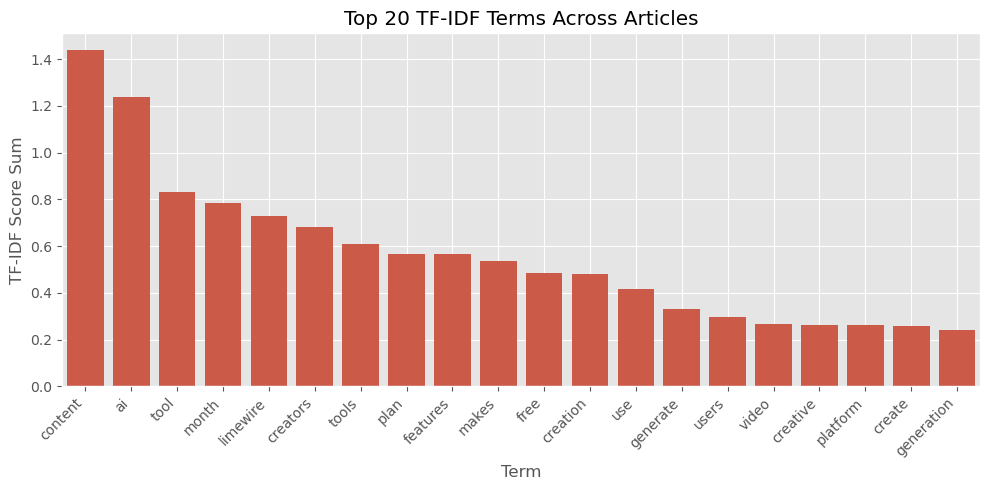

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
# Fit and transform the text column
X = vectorizer.fit_transform(df['text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# Show top TF-IDF features across all documents
tfidf_sums = tfidf_df.sum().sort_values(ascending=False)
# Plot the top terms
plt.figure(figsize=(10, 5))
sns.barplot(x=tfidf_sums.index, y=tfidf_sums.values)
plt.title("Top 20 TF-IDF Terms Across Articles")
plt.ylabel("TF-IDF Score Sum")
plt.xlabel("Term")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()